## Configuration for Colab

In [31]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 05. Soft Actor Critic (SAC)

1. [T. Haarnoja et al., "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290, 2018.](https://arxiv.org/pdf/1801.01290.pdf)
2. [T. Haarnoja et al., "Soft Actor-Critic Algorithms and Applications." arXiv preprint arXiv:1812.05905, 2018.](https://arxiv.org/pdf/1812.05905.pdf)

The main purpose of SAC is to maximize the actor's entropy while maximizing expected reward. We can expect both sample efficient learning and stability because maximizing entropy provides a substantial improvement in exploration and robustness.

As an extension of standard RL's objective function $\sum_t \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t)]$, let's consider a more general maximum entropy objective which favors stochastic policies by augmenting the objective with the expected entropy of the policy over $\rho_\pi (s_t)$:

$$J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))].$$

The temperature parameter $\alpha$ determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy. By this objective, the policy can explore more widely and capture multiple modes of near-optimal behavior. In conclusion, it considerably improves learning speed over other methods that optimize the conventional RL objective function.

In the paper, the authors show that *Soft Policy Iteration* guarantees convergence based on a tabular setting (4.1), and they extend it to a practical approximation for large continuous domains (4.2). Firstly, the soft value function is trained to minimize the squared residual error:

$$J_V (\psi) = \mathbb{E}_{s_t \sim D} \big[ \frac{1}{2}(v_\psi (s_t) - \mathbb{E}_{a_t \sim \pi_\phi} [Q_\theta(s_t, a_t) - \log_{\pi_\phi}(a_t | s_t)])^2 \big],$$

where $D$ is the distribution of previously sampled states and actions, or a replay buffer. Second, the soft Q-function parameters can be trained to minimize the soft Bellman residual:

$$J_Q (\theta) = \mathbb{E}_{(s_t, a_t) \sim D} \big[ \frac{1}{2} \big( Q_\theta(s_t, a_t) - \hat{Q}(s_t, a_t) \big)^2 \big],$$

with $\hat{Q}(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1} \sim \rho} [V_{\tilde{\psi}} (s_{t+1})].$

Finally, the policy paramameters can be learned by directly minimizing the following expected KL-divergence:

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D} \big[ D_{KL} \big( \pi_{\phi} (\cdot | s_t) \| \frac{\exp(Q_{\theta}(s_t, \cdot))}{Z_\theta(s_t)} \big) \big].$$

We can rewirte the objective as

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D, \epsilon_t \sim N} [ \log_{\pi_\phi}(f_\phi(\epsilon_t ; s_t) | s_t) - Q_\theta (s_t, f_\phi (\epsilon_t ; s_t))],$$

where $\pi_\phi$ is defined implicitly in terms of $f_\phi$, and the partition function is independent of $\phi$ and can thus be omitted.

One thing to note is that the authors suggest to use two Q-functions to mitigate positive bias in the policy improvement step that is known to degrade performance of value based methods. In particular, we parameterize two Q-functions, with parameters $\theta_i$, and train them independently to optimize $J_Q(\theta_i)$. We then use the minimum of the Q-functions for the value gradient and policy gradient. Two Q-functions can significantly speed up training, especially on harder tasks.

### Can we do better?

In Soft Actor Critic paper, the experiment of reward scale shows that SAC's performance quite varies depending on reward scaling. In the follow-up paper [2], the authors assume that the temperature parameter $\alpha$ needs to be adjusted depending on the magnitude of the reward, and they define the soft policy optimization as a constrained problem.

$$\max_{\pi_{0:T}} \mathbb{E}_{\rho_\pi} \big[ \sum_{t=0}^T r(s_t, a_t) \big] \text{ s.t. } \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [-\log(\pi_t(a_t|s_t))] \ge H \text{ for all } t,$$

where $H$ is a desired minimum expected entropy. This constrained maximization becomes the following dual problem.

$$\min_{a_T \ge 0} \max_{\pi_T} \mathbb{E} [r(s_T, a_T) - \alpha_T \log \pi(a_t|s_t)] - \alpha_T H,$$

where $\alpha_T$ is the dual variable. Furthermore, it can be rewrited as a optimization problem with regards to $\alpha$.

$$J(\alpha) = \mathbb{E}_{a_t \sim \pi_t} [-\alpha \log \pi_t (a_t | s_t) - \alpha H].$$

By optimizing this dual problem, we can adjust the dual variable $\alpha$, which plays the role of the temperature.

## Import modules

In [32]:
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Set random seed

In [33]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [34]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initialize."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network
We are going to use three different networks for policy, Q-function, and V-function. We use two Q-functions to mitigate positive bias and softly update V-function for stable learning. One interesting thing is that the policy network works as Tanh Normal distribution which enforces action bounds. (The details are descibed in Appendix C of [2].)

In [35]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer


class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        log_std_min: float = -20,
        log_std_max: float = 2,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        # set the log std range
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        # set the hidden layers
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        
        # set log_std layer
        self.log_std_layer = nn.Linear(128, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

        # set mean layer
        self.mu_layer = nn.Linear(128, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        
        # get mean
        mu = self.mu_layer(x).tanh()
        
        # get std
        log_std = self.log_std_layer(x).tanh()
        log_std = self.log_std_min + 0.5 * (
            self.log_std_max - self.log_std_min
        ) * (log_std + 1)
        std = torch.exp(log_std)
        
        # sample actions
        dist = Normal(mu, std)
        z = dist.rsample()
        
        # normalize action and log_prob
        # see appendix C of [2]
        action = z.tanh()
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob
    
    
class CriticQ(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticQ, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value
    
    
class CriticV(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticV, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

## SAC Agent
Here is a summary of SACAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [36]:
class SACAgent:
    """SAC agent interacting with environment.
    
    Attrtibutes:
        actor (nn.Module): actor model to select actions
        actor_optimizer (Optimizer): optimizer for training actor
        vf (nn.Module): critic model to predict state values
        vf_target (nn.Module): target critic model to predict state values
        vf_optimizer (Optimizer): optimizer for training vf
        qf_1 (nn.Module): critic model to predict state-action values
        qf_2 (nn.Module): critic model to predict state-action values
        qf_1_optimizer (Optimizer): optimizer for training qf_1
        qf_2_optimizer (Optimizer): optimizer for training qf_2
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        policy_update_freq (int): policy update frequency
        device (torch.device): cpu / gpu
        target_entropy (int): desired entropy used for the inequality constraint
        log_alpha (torch.Tensor): weight for entropy
        alpha_optimizer (Optimizer): optimizer for alpha
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # automatic entropy tuning
        self.target_entropy = -np.prod((action_dim,)).item()  # heuristic
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=3e-4)

        # actor
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        
        # v function
        self.vf = CriticV(obs_dim).to(self.device)
        self.vf_target = CriticV(obs_dim).to(self.device)
        self.vf_target.load_state_dict(self.vf.state_dict())
        
        # q function
        self.qf_1 = CriticQ(obs_dim + action_dim).to(self.device)
        self.qf_2 = CriticQ(obs_dim + action_dim).to(self.device)

        # optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.vf_optimizer = optim.Adam(self.vf.parameters(), lr=3e-4)
        self.qf_1_optimizer = optim.Adam(self.qf_1.parameters(), lr=3e-4)
        self.qf_2_optimizer = optim.Adam(self.qf_2.parameters(), lr=3e-4)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            )[0].detach().cpu().numpy()
            
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, ...]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        new_action, log_prob = self.actor(state)
        
        # train alpha (dual problem)
        alpha_loss = (
            -self.log_alpha.exp() * (log_prob + self.target_entropy).detach()
        ).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        alpha = self.log_alpha.exp()  # used for the actor loss calculation
        
        # q function loss
        mask = 1 - done
        q_1_pred = self.qf_1(state, action)
        q_2_pred = self.qf_2(state, action)
        v_target = self.vf_target(next_state)
        q_target = reward + self.gamma * v_target * mask
        qf_1_loss = F.mse_loss(q_1_pred, q_target.detach())
        qf_2_loss = F.mse_loss(q_2_pred, q_target.detach())
        
        # v function loss
        v_pred = self.vf(state)
        q_pred = torch.min(
            self.qf_1(state, new_action), self.qf_2(state, new_action)
        )
        v_target = q_pred - alpha * log_prob
        vf_loss = F.mse_loss(v_pred, v_target.detach())
        
        if self.total_step % self.policy_update_freq == 0:
            # actor loss
            advantage = q_pred - v_pred.detach()
            actor_loss = (alpha * log_prob - advantage).mean()
            
            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
            # target update (vf)
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(1)
            
        # train Q functions
        self.qf_1_optimizer.zero_grad()
        qf_1_loss.backward()
        self.qf_1_optimizer.step()

        self.qf_2_optimizer.zero_grad()
        qf_2_loss.backward()
        self.qf_2_optimizer.step()
        
        qf_loss = qf_1_loss + qf_2_loss

        # train V function
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()
        
        return actor_loss.data, qf_loss.data, vf_loss.data, alpha_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        actor_losses, qf_losses, vf_losses, alpha_losses = [], [], [], []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                losses = self.update_model()
                actor_losses.append(losses[0])
                qf_losses.append(losses[1])
                vf_losses.append(losses[2])
                alpha_losses.append(losses[3])
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step,
                    scores, 
                    actor_losses, 
                    qf_losses, 
                    vf_losses, 
                    alpha_losses
                )
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.vf_target.parameters(), self.vf.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float],
        qf_losses: List[float],
        vf_losses: List[float],
        alpha_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (151, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (152, "actor_loss", actor_losses),
            (153, "qf_loss", qf_losses),
            (154, "vf_loss", vf_losses),
            (155, "alpha_loss", alpha_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [37]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [38]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id, new_step_api=True)
env = ActionNormalizer(env, new_step_api=True)

## Initialize

In [39]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
initial_random_steps = 10000

agent = SACAgent(
    env, memory_size, batch_size, initial_random_steps=initial_random_steps
)

cpu


## Train

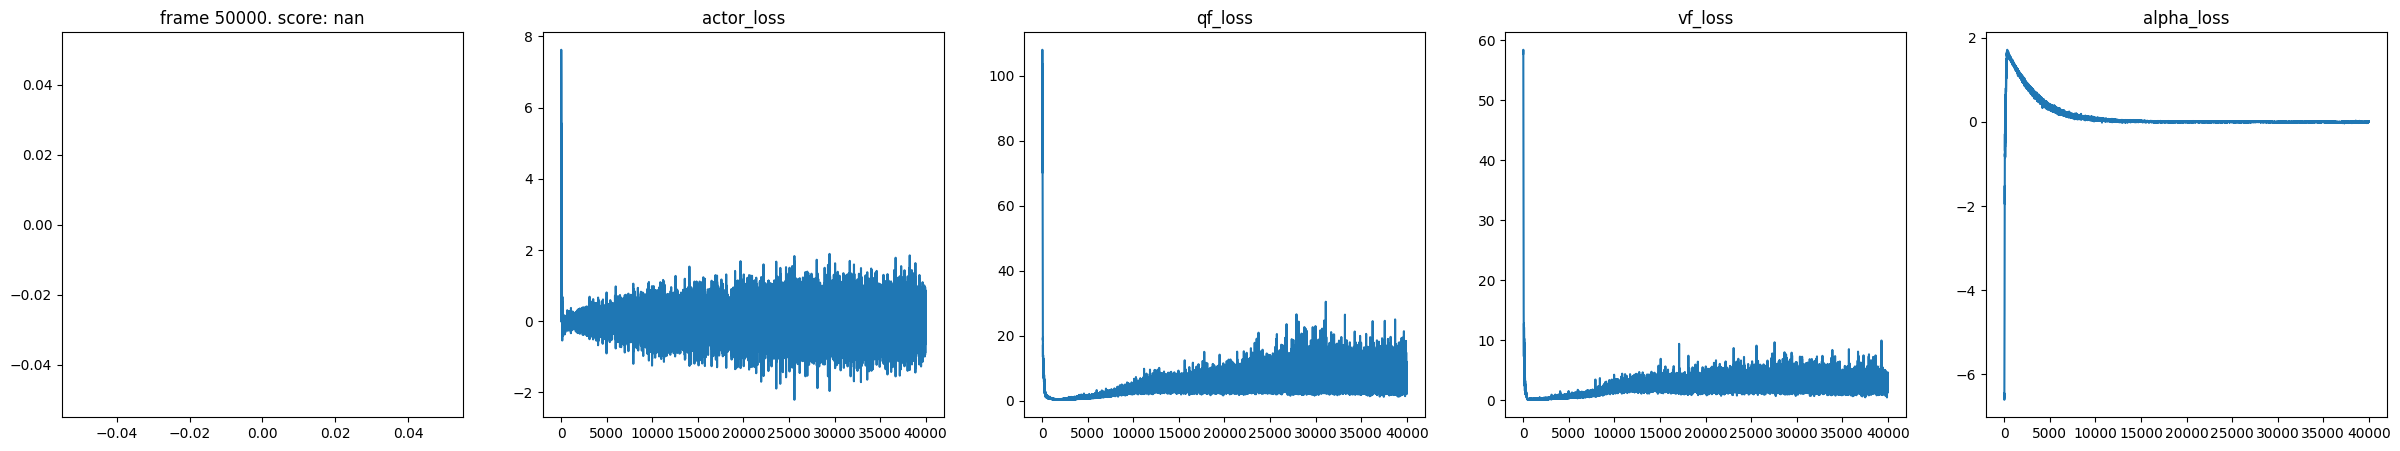

In [40]:
agent.train(num_frames)